In [1]:
!pip install streamlit pyngrok  pillow


In [3]:
!pip install  opencv-python numpy torch torchvision  matplotlib tqdm pyngrok


  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   - -------------------------------------- 6.0/204.1 MB 30.7 MB/s eta 0:00:07
   -- ------------------------------------- 12.8/204.1 MB 30.9 MB/s eta 0:00:07
   --- ------------------------------------ 19.7/204.1 MB 31.8 MB/s eta 0:00:06
   ----- ---------------------------------- 26.2/204.1 MB 31.9 MB/s eta 0:00:06
   ------ --------------------------------- 33.0/204.1 MB 32.3 MB/s eta 0:00:06
   ------- -------------------------------- 40.1/204.1 MB 32.3 MB/s eta 0:00:06
   --------- ------------------------------ 47.2/204.1 MB 32.6 MB/s eta 0:00:05
   ---------- ----------------------------- 54.3/204.1 MB 32.6 MB/s eta 0:00:05
   ------------ --------------------------- 61.3/204.1 MB 32.8 MB/s eta 0:00:

In [5]:
!pip install tensorflow

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import streamlit as st
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
from pyngrok import ngrok
import os
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from glob import glob
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

In [ ]:


# ========== SET PARAMETERS ==========
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 1e-4

# ========== DATA LOADING FUNCTION ==========
def load_data(image_folder, mask_folder):
    """ Load image and mask paths """
    image_paths = sorted(glob(os.path.join(image_folder, "*.png")))
    mask_paths = sorted(glob(os.path.join(mask_folder, "*.png")))
    return image_paths, mask_paths

# ========== IMAGE PREPROCESSING & DATA AUGMENTATION ==========
def preprocess_image(image_path, mask_path):
    """ Load and preprocess an image-mask pair """
    image = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    mask = load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")

    image = img_to_array(image) / 255.0  # Normalize to [0,1]
    mask = img_to_array(mask) / 255.0  # Normalize mask to [0,1]

    return image, mask

def data_generator(image_paths, mask_paths, batch_size):
    """ Data generator for training """
    data_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1
    )

    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_images = []
            batch_masks = []

            for j in range(i, min(i + batch_size, len(image_paths))):
                img, mask = preprocess_image(image_paths[j], mask_paths[j])
                batch_images.append(img)
                batch_masks.append(mask)

            batch_images = np.array(batch_images)
            batch_masks = np.array(batch_masks)

            augmented = next(data_gen.flow(batch_images, batch_size=batch_size, seed=42))
            yield augmented, batch_masks

# ========== PLANENET MODEL ==========
def build_planenet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    """ PlaneNet-like segmentation model with ResNet-101 encoder """
    inputs = Input(shape=input_shape)

    # Encoder: ResNet-101 backbone
    resnet = ResNet101(include_top=False, weights="imagenet", input_tensor=inputs)
    for layer in resnet.layers:
        layer.trainable = False  # Freeze ResNet layers

    # Decoder (U-Net style upsampling)
    x = Conv2D(256, (3, 3), padding="same", activation="relu")(resnet.output)
    x = UpSampling2D((2, 2))(x)  # 7x7 → 14x14
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = UpSampling2D((2, 2))(x)  # 14x14 → 28x28
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = UpSampling2D((2, 2))(x)  # 28x28 → 56x56
    x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = UpSampling2D((2, 2))(x)  # 56x56 → 112x112
    x = Conv2D(16, (3, 3), padding="same", activation="relu")(x)
    x = UpSampling2D((2, 2))(x)  # 112x112 → 224x224

    # Final segmentation output
    output = Conv2D(1, (1, 1), activation="sigmoid")(x)  # Binary segmentation

    model = Model(inputs, output)
    return model

# ========== TRAINING FUNCTION ==========
def train_planenet(image_folder, mask_folder):
    """ Train the PlaneNet model """
    # Load dataset
    image_paths, mask_paths = load_data(image_folder, mask_folder)

    # Train-test split
    split = int(len(image_paths) * 0.8)
    train_images, val_images = image_paths[:split], image_paths[split:]
    train_masks, val_masks = mask_paths[:split], mask_paths[split:]

    # Create model
    model = build_planenet()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss="binary_crossentropy", metrics=["accuracy"])

    # Callbacks
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ModelCheckpoint("planenet_best_model.h5", save_best_only=True)
    ]

    # Train the model
    model.fit(data_generator(train_images, train_masks, BATCH_SIZE),
              validation_data=data_generator(val_images, val_masks, BATCH_SIZE),
              steps_per_epoch=len(train_images) // BATCH_SIZE,
              validation_steps=len(val_images) // BATCH_SIZE,
              epochs=10,
              callbacks=callbacks)

    return model

# ========== PREDICTION & VISUALIZATION ==========
def predict_and_visualize(model, test_image_path):
    """ Predict and visualize segmentation results """
    image = load_img(test_image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    pred_mask = model.predict(image)[0, :, :, 0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Thresholding

    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(load_img(test_image_path))
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Segmentation")
    plt.show()

# ========== MAIN FUNCTION ==========
def main():
    image_folder = "/content/drive/MyDrive/dataset/corridor/images"
    mask_folder = "/content/drive/MyDrive/dataset/corridor/masks"

    model = train_planenet(image_folder, mask_folder)






In [ ]:
# ========== RUN SCRIPT ==========
if __name__ == "__main__":
    main()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7707 - loss: 0.5503

23/23 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.7719 - loss: 0.5479 - val_accuracy: 0.8116 - val_loss: 0.4387
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8107 - loss: 0.4486

23/23 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - accuracy: 0.8111 - loss: 0.4478 - val_accuracy: 0.8076 - val_loss: 0.4331
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8133 - loss: 0.4308

23/23 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.8135 - loss: 0.4305 - val_accuracy: 0.8304 - val_loss: 0.3983
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.8277 - loss: 0.4036 - val_accuracy: 0.8280 - val_loss: 0.4020
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.8269 - loss: 0.4007 - val_accuracy: 0.8299 - val_loss: 0.4008
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.8305 - loss: 0.3929 - val_accuracy: 0.8303 - val_loss: 0.4014
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.8262 - loss: 0.4008 - val_accuracy: 0.8128 - val_loss: 0.4288
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.8342 - loss: 0.3849 - val_accuracy: 0.8147 - val_loss: 0.4210
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8443 - loss: 0.3675

23/23 ━━━━━━━━━━━━━━━━━━━━ 146s 6s/step - accuracy: 0.8435 - loss: 0.3689 - val_accuracy: 0.8330 - val_loss: 0.3870
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - accuracy: 0.8415 - loss: 0.3702 - val_accuracy: 0.8306 - val_loss: 0.3887


In [9]:
from tensorflow.keras.models import load_model
model_path = r"C:\Users\KEERTHI KRISHANA\Downloads\planenet_best_model.h5"
# Load the saved model
model = load_model(model_path)

# Check the model summary to verify successful loading
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 47,768,963 (182.22 MB)

 Trainable params: 5,110,785 (19.50 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

 Optimizer params: 2 (12.00 B)

In [88]:
# ========== SET PARAMETERS ==========
IMG_HEIGHT = 224
IMG_WIDTH = 224

# ========== COLOR MAPS ==========
WALL_COLOR = [0, 255, 0]  # Green
FLOOR_COLOR = [0, 0, 255]  # Blue

# ========== IMAGE PREPROCESSING FUNCTION ==========
def preprocess_image(image):
    """ Resize and normalize an input image """
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = image / 255.0  # Normalize
    return np.expand_dims(image, axis=0)

# ========== FUNCTION TO APPLY MASK OVERLAY ==========
def apply_mask(image, mask):
    """ Apply color-coded segmentation masks (Wall = Green, Floor = Blue) """

    # Resize the mask to match the original image dimensions
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    colored_mask = np.zeros_like(image)

    # Walls (mask == 1) → Green
    colored_mask[mask == 1] = WALL_COLOR

    # Floor (mask == 0) → Blue
    colored_mask[mask == 0] = FLOOR_COLOR

    # Overlay mask on the original image
    overlayed = cv2.addWeighted(image, 0.6, colored_mask, 0.4, 0)
    return overlayed

# ========== FUNCTION TO COMPUTE METRICS ==========
def compute_metrics(pred_mask, gt_mask):
    """ Calculate IoU, Accuracy, Precision, Recall, and F1 Score """

    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    iou = np.sum((pred_flat & gt_flat)) / np.sum((pred_flat | gt_flat)) if np.sum((pred_flat | gt_flat)) > 0 else 0

    accuracy = accuracy_score(gt_flat, pred_flat)
    precision = precision_score(gt_flat, pred_flat, zero_division=1)
    recall = recall_score(gt_flat, pred_flat, zero_division=1)
    f1 = f1_score(gt_flat, pred_flat, zero_division=1)

    return iou, accuracy, precision, recall, f1

# ========== FUNCTION TO TEST MODEL ON A ROOM IMAGE ==========
def test_on_image(image_path, gt_mask_path=None):
    """ Test the model on an input image and display segmentation results """
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Preprocess & predict
    input_image = preprocess_image(image_rgb)
    predictions = model.predict(input_image)

    pred_mask = (predictions[0, :, :, 0] > 0.5).astype(np.uint8)  # Segmentation mask

    # Apply mask overlay
    overlayed_image = apply_mask(image_rgb, pred_mask)

    # Compute metrics if ground truth is available
    if gt_mask_path:
        gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
        gt_mask = cv2.resize(gt_mask, (IMG_WIDTH, IMG_HEIGHT))
        gt_mask = (gt_mask > 127).astype(np.uint8)

        iou, accuracy, precision, recall, f1 = compute_metrics(pred_mask, gt_mask)

        print(f"IoU: {iou:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Display results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Segmentation Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_image)
    plt.title("Overlayed Result")
    plt.axis("off")

    plt.show()

# ========== FUNCTION TO RUN LIVE CAMERA SEGMENTATION ==========
def capture_live_image():
    """ Capture a single image from the webcam and perform segmentation """
    cap = cv2.VideoCapture(0)  # Open webcam
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("Failed to capture image.")
        return

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    input_image = preprocess_image(frame_rgb)

    # Predict segmentation mask
    predictions = model.predict(input_image)
    pred_mask = (predictions[0, :, :, 0] > 0.5).astype(np.uint8)

    # Apply overlay
    overlayed_frame = apply_mask(frame_rgb, pred_mask)

    # Display results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(frame_rgb)
    plt.title("Captured Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Segmentation Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlayed_frame)
    plt.title("Overlayed Result")
    plt.axis("off")

    plt.show()
# ========== MAIN FUNCTION ==========
def main():
    choice = input("Enter '1' for image testing, '2' for live segmentation: ")

    if choice == '1':
        image_path = r"C:\Users\KEERTHI KRISHANA\Downloads\raw_image\frame_001.png"  # Replace with your test image path
        gt_mask_path = r"C:\Users\KEERTHI KRISHANA\Downloads\ground_truth\frame_001_mask.png"  # Replace with GT mask path
        test_on_image(image_path, gt_mask_path)
    elif choice == '2':
        print("Starting live room segmentation... Press 'q' to exit.")
        live_segmentation()
    else:
        print("Invalid choice!")


Enter '1' for image testing, '2' for live segmentation:  1


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
IoU: 0.4987, Accuracy: 0.7578, Precision: 0.4987, Recall: 1.0000, F1 Score: 0.6655


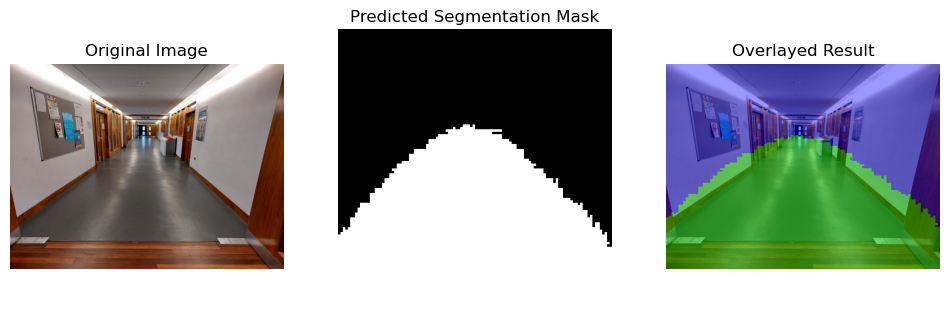

In [90]:
# ========== RUN SCRIPT ==========
if __name__ == "__main__":
    main()

In [78]:
file_path = r"C:\Users\KEERTHI KRISHANA\Downloads\segapp.py"

script_content = """\
import streamlit as st
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image

# ========== SET PARAMETERS ==========
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Load the model
MODEL_PATH = r"C:\\Users\\KEERTHI KRISHANA\\Downloads\\planenet_best_model.h5"

@st.cache_resource
def load_model():
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)  # Disable compilation during loading
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])  # Recompile manually
    return model

model = load_model()

# ========== COLOR MAPS ==========
WALL_COLOR = [0, 255, 0]  # Green
FLOOR_COLOR = [0, 0, 255]  # Blue

# ========== IMAGE PREPROCESSING FUNCTION ==========
def preprocess_image(image):
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))  # Resize image
    image = image / 255.0  # Normalize
    return np.expand_dims(image, axis=0)

# ========== FUNCTION TO APPLY MASK OVERLAY ==========
def apply_mask(image, mask):
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    colored_mask = np.zeros_like(image)
    colored_mask[mask == 1] = WALL_COLOR  # Walls = Green
    colored_mask[mask == 0] = FLOOR_COLOR  # Floor = Blue
    overlayed = cv2.addWeighted(image, 0.6, colored_mask, 0.4, 0)
    return overlayed

# ========== FUNCTION TO MAKE PREDICTIONS ==========
def predict_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_image = preprocess_image(image_rgb)
    predictions = model.predict(input_image)
    pred_mask = (predictions[0, :, :, 0] > 0.5).astype(np.uint8)  # Generate segmentation mask
    overlayed_image = apply_mask(image_rgb, pred_mask)
    return image_rgb, pred_mask, overlayed_image

# ========== STREAMLIT UI ==========
st.title("Room Segmentation")

# Upload Image
uploaded_file = st.file_uploader("Upload an image", type=["jpg", "png", "jpeg"])

if uploaded_file:
    image = Image.open(uploaded_file)
    image = np.array(image)
    st.image(image, caption="Uploaded Image", use_column_width=True)

    if st.button("Predict"):
        orig, mask, overlayed = predict_image(image)
        st.image(overlayed, caption="Overlayed Segmentation", use_column_width=True)

# ========== LIVE WEBCAM CAPTURE ==========
if st.button("Capture from Webcam"):
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    cap.release()

    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        orig, mask, overlayed = predict_image(frame_rgb)
        st.image(frame_rgb, caption="Captured Image", use_column_width=True)
        st.image(overlayed, caption="Overlayed Result", use_column_width=True)
    else:
        st.error("Failed to capture image. Please check your webcam.")

"""

# Save the script
with open(file_path, "w", encoding="utf-8") as f:
    f.write(script_content)

print(f"File saved as {file_path}")


File saved as C:\Users\KEERTHI KRISHANA\Downloads\segapp.py


In [82]:
!streamlit run app.py --server.port 8510 --browser.serverAddress localhost


^C
